In [286]:
import networkx as nx
import numpy as np
log = True

In [287]:
def get_neighbor_opinion_distribution(G, node, exclude = None):
    """
    Return bin count of the opinions of the neighbors
    """ 
    count = {}
    for neigh in nx.neighbors(G, node):
        opinion = G.nodes[neigh]['opinion']
        if opinion != exclude:
            count[opinion] = count.get(opinion, 0) + 1
    return count

In [288]:
def get_majority_opinion(G, node):
    """
    Calculate the majority opinion of the nodes, i.e., the opinion held by the largest 
    number of individuals among the neighbors of the node.
    """
    count = get_neighbor_opinion_distribution(G, node)
    max_count = 0
    maj_opinion = None
    for o, c in count.items():
        if c > max_count:
            maj_opinion = o
            max_count = c  
    return maj_opinion        

In [289]:
def rewire(G, node, phi):
    node_opinion = G.nodes[node]['opinion']
    count = get_neighbor_opinion_distribution(G, node, exclude = node_opinion)
    if not count:
        return 1
    min_opinion_count = min(count.values()) 
    candidate_removal_nodes = [ neigh for neigh in nx.neighbors(G, node) if 
                                G.nodes[neigh]['opinion'] != node_opinion and
                                count[G.nodes[neigh]['opinion']] == min_opinion_count and
                                G.degree[neigh] > 1
                               ]
    if not candidate_removal_nodes:
        return 2
    neigh_remove = np.random.choice(candidate_removal_nodes)
    neigh_add = None
    rule = np.random.binomial(1, phi)
    # rewire to neighbor of neighbors with same opinion
    if rule == 1:
        neighbor_of_neighbors = { neigh_of_neigh 
                                for neigh in nx.neighbors(G, node) 
                                for neigh_of_neigh in nx.neighbors(G, neigh) 
                                if G.nodes[neigh_of_neigh]['opinion'] == node_opinion
                                }
        neighbor_of_neighbors.remove(node)
        neighbor_of_neighbors -= set(nx.neighbors(G, node))
        if not neighbor_of_neighbors:
            return 3
        neigh_add = np.random.choice(np.fromiter(neighbor_of_neighbors, int, len(neighbor_of_neighbors))) 
    # rewire to any non-neighboring node in the network with same opinion
    elif rule == 0:
        candidates = { other_node 
                       for other_node in nx.nodes(G)
                       if G.nodes[other_node]['opinion'] == node_opinion
                    }   
        candidates.remove(node)
        candidates -= set(nx.neighbors(G, node))
        if not candidates:
            return 4
        neigh_add = np.random.choice(np.fromiter(candidates, int, len(candidates)))
    G.remove_edge(node, neigh_remove)    
    G.add_edge(node, neigh_add)
    if not nx.is_connected(G):
        # undo removal and addition of neighbors if it results in a disconnected graph
        G.remove_edge(node, neigh_add)    
        G.add_edge(node, neigh_remove)
        return 5
    if log:
        print('MA for node {} -> rule:{}, neigh_removed:{}, neigh_added:{}'
              .format(node, rule, neigh_remove, neigh_add))
    return 0

In [290]:
class Simulation:
    def __init__(self, N=15, avg_degree=5, p=0.5, phi=0.5, G=3):
        self.N = N
        self.k = avg_degree
        self.p = p
        self.phi = phi
        self.G = G
        self.time = 0
        self.stall = 0
        self.stall_bin = {}
        self.graph = nx.gnp_random_graph(N, avg_degree/N)
        self.status = 0
        # Guarantee initial graph is connected
        i = 0
        while(not nx.is_connected(self.graph)):
            if i == 5:
                raise RuntimeError("Couldn't generate connected random graph.")
            else:   
               self.graph = nx.gnp_random_graph(N, avg_degree/N)
               i += 1            
        self.init_opinions()
    def init_opinions(self):
        """ 
        Set the opinion of all individuals in the graph. 
        All opinions are equally likely (uniform distribution).
        """
        opinions = {i: np.random.choice(self.G) for i in range(self.N)}
        nx.set_node_attributes(self.graph, opinions, 'opinion')
    def step(self):
        """ 
        One step of the simulation. Application of one of the rules to a single node. 
        """
        # choose between MA and MP according to the parameter p
        rule = np.random.binomial(1, self.p)
        # choose a random node to apply the rule to
        node = np.random.choice(nx.nodes(self.graph))
        error_code = 0
        # rule==1 -> Apply majority preference rule to node
        if rule == 1:
            maj_opinion = get_majority_opinion(self.graph, node)
            if log:    
                prev_opinion = self.graph.nodes[node]['opinion']
                print('MP for node {} -> prev_opinion:{}, curr_opinion:{}'.format(node, prev_opinion, maj_opinion))
            self.graph.nodes[node]['opinion'] = maj_opinion
        # rule==0 -> Apply minority avoidance rule to node
        else:  
           error_code = rewire(self.graph, node, self.phi) 
        if not error_code:
            self.time += 1
        # error_code 1 means the node doesn't have neighbors with an opinion different than his
        # so it's no problem since it just means the node converged already
        elif error_code != 1:
            self.stall += 1
            self.stall_bin[error_code] = self.stall_bin.get(error_code, 0) + 1
    def stop_condition(self):
        """
        When we reach the consensus state we can stop the simulation, i.e., when each individuals
        opinion agrees with the majority of its neighbors.
        """
        def agrees_with_majority(node):
            count = get_neighbor_opinion_distribution(self.graph, node)
            max_opinion_count = max(count.values()) 
            return count.get(self.graph.nodes[node]['opinion'], 0) == max_opinion_count
        return all(
                agrees_with_majority(node)
                for node in nx.nodes(self.graph)
             )
    def run(self):
        if self.status:
            return self.status
        while(not self.stop_condition()):
            self.step()
            # Here we expect more stalls with more nodes, less connectedness and
            # larger phi (since a larger phi means we are constraining who we can connect to).
            # If the stalls are much larger than the time we stop the simulation with an error.
            if self.stall >= 20 + self.time * (self.phi + 1) * np.log2(self.N) / self.k:
                self.status = -1
                return 1
        self.status = 1    
        return 0

In [291]:
def draw(G):
    nx.draw(G, with_labels= True, node_color=list(nx.get_node_attributes(G, "opinion").values()))

[(0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
{0: 0, 1: 2, 2: 1, 3: 2, 4: 1}


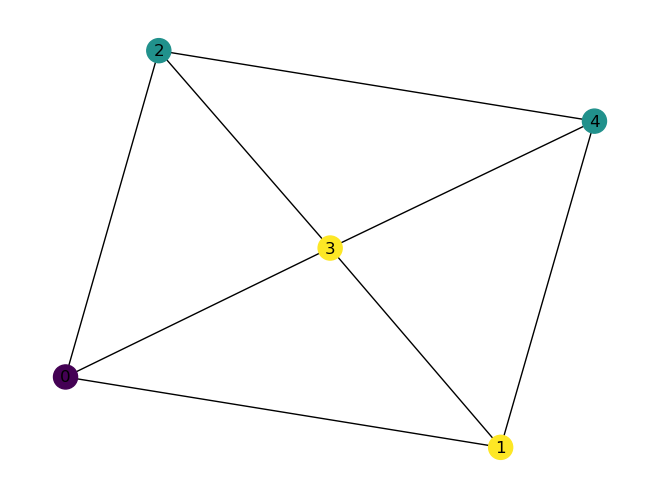

In [292]:
simul = Simulation(N = 5, avg_degree = 4, p=0)
G = simul.graph
print(simul.graph.edges)
print(nx.get_node_attributes(G, "opinion"))
draw(G)

{0: 0, 1: 2, 2: 1, 3: 2, 4: 1}


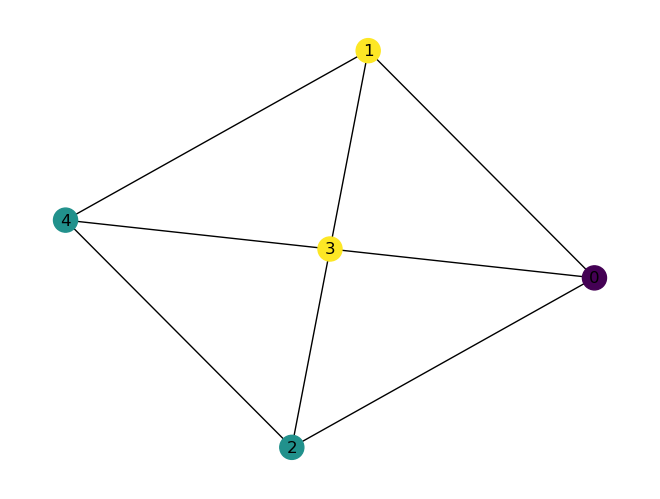

In [293]:
for _ in range(5) :
    simul.step()
print(nx.get_node_attributes(G, "opinion"))
draw(G)

-1 0 20
{3: 13, 4: 7}


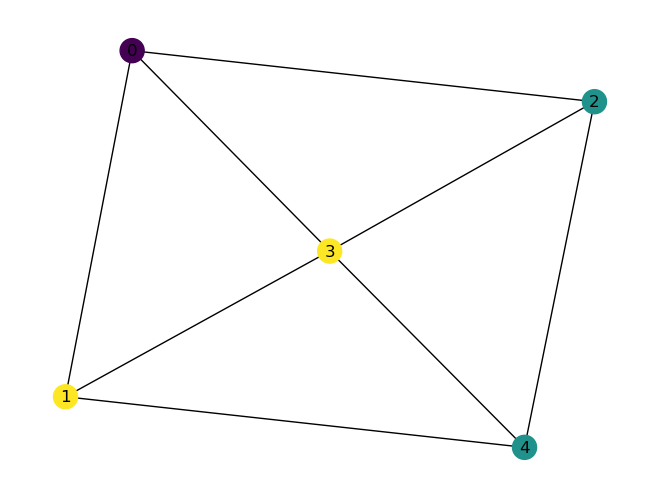

In [294]:
simul.run()
draw(G)
print(simul.status, simul.time, simul.stall)
print(simul.stall_bin)